# Collaboration Network Analysis

## 0. Initialize

In [1]:
import networkx as nx
from pyvis.network import Network

In [2]:
# global variables

data_cache_prefix = 'data_cache/'
graph_suffix = '.adjlist.gz'
json_suffix = '.json.gz'
database_file = data_cache_prefix+"author.db"

In [3]:
# caching helpers
from lib.cache import *

In [4]:
# database helpers
from lib.db import *


## 1. Load and preprocess the collaboration data.

In [5]:
# Process author data and store to database

'''
#index 1
#n O. Willum
#a Res. Center for Microperipherik, Technische Univ. Berlin, Germany
#pc 1
#cn 0
#hi 0
#pi 0.0000
#upi 0.0000
#t new product;product group;active product;long product lifetime;old product;product generation;new technology;environmental benefit;environmental choice;environmental consequence
'''
def process_author_sqlite():
    with open('data/AMiner-Author.txt', 'r') as file:
        data = file.read().split('\n\n')

    database = data_cache_prefix+"author.db"
    conn = create_connection(database)

    # create tables
    if conn is None:
        # create projects table
        print("Error! cannot create the database connection.")
    else:
        with conn:
            create_author_table(conn)

            detail = ['index', 'n', 'a', 'pc', 'cn', 'hi', 'pi', 'upi', 't']
            total = len(data)
            for n, auth in enumerate(data):
                info = auth.split('\n')
                if info[0] is '':
                    break
                index = info[0].split(' ')[1]
                author = [0,0,0,0,0,0,0,0,0]
                for num,each in enumerate(detail):
                    author[num] = info[num].replace('#'+each+' ', '')
                create_author(conn, author)
                if n % 10000 == 0:
                    print("processed %d/%d"%(n,total))
    conn.close()

if os.path.isfile(database_file):
    print('%s already exist, skipping author processing'%database_file)
else:
    print('processing authors')
    process_author_sqlite()

data_cache/author.db already exist, skipping author processing


In [6]:
def filter(keyword, by_type):
    with create_connection(database_file) as conn:
        rows = conn.cursor().execute(
            f"""
            SELECT idx FROM authors WHERE {by_type} LIKE '%'||?||'%'
            """
        ,[keyword]).fetchall()
        return [row[0] for row in rows]

In [7]:
coauthorfile = open('data/AMiner-Coauthor.txt')
coauthors = []
for line in coauthorfile:
    author1, author2, count = line[1:].split('\t')
    coauthors.append((author1, author2, int(count)))

In [8]:
coauthors[:10]

[('522324', '1034146', 1),
 ('1355779', '1229932', 2),
 ('688814', '947067', 2),
 ('1329221', '1140429', 1),
 ('742331', '314944', 1),
 ('898041', '1061829', 1),
 ('1075448', '1040028', 1),
 ('1218654', '1244844', 2),
 ('117148', '364153', 2),
 ('1335705', '738530', 1)]

In [9]:
sortedcoauthors = sorted(coauthors, key = lambda coauth: -coauth[2])
sortedcoauthors[:10]

[('111806', '977442', 320),
 ('966551', '111806', 320),
 ('966551', '977442', 320),
 ('980079', '68033', 310),
 ('549347', '80953', 306),
 ('324627', '33938', 234),
 ('860814', '1693619', 216),
 ('946534', '1536687', 194),
 ('833156', '815734', 143),
 ('218997', '173556', 132)]

## 2. Visualize the top 10 collaboration pairs

In [10]:
# Credit: https://gist.github.com/quadrismegistus/92a7fba479fc1e7d2661909d19d4ae7e

def visualize(networkx_graph, name):
    pyvis_graph = Network(height=800, width=800, notebook=True)
    for node,node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(node,**node_attrs)

    # for each edge and its attributes in the networkx graph
    for source,target,edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value']=edge_attrs['weight']
        # add the edge
        pyvis_graph.add_edge(source,target,**edge_attrs)

    return pyvis_graph.show('docs/' + name)

In [11]:
def make_graph(coauth_tuples):
    G = nx.Graph()
    for coauthor in coauth_tuples:
        G.add_edge(coauthor[0], coauthor[1], weight=coauthor[2])
    return G

In [12]:
#remove all disconnected nodes to node

import copy
def remove_disconnected(G, node):
    node_list = copy.deepcopy(nx.nodes(G))
    for each in node_list:
        if nx.has_path(G,source=each, target=node) == 0:
            G.remove_node(each)
    return G

In [13]:
# visualize(make_graph(sortedcoauthers[:10]), 'top10.html')

In [14]:
# visualize(make_graph(sortedcoauthers[:1000]), 'top1000.html')

In [15]:
G = open_or_compute_graph('whole_graph',lambda: make_graph(coauthors))
print('whole graph connected: ',nx.is_connected(G))
print('numbers of node in whole graph',G.number_of_nodes())

# finding maximum degree node of whole graph
node_id = []
deg = 0

for node in nx.nodes(G):
    if G.degree[node] > deg:
        node_id = [node]
        deg = G.degree[node]
    elif G.degree[node] == deg:
        node_id.append(node)  
print("nodes with maximum degree", node_id)
print('degree' ,deg)

loaded cached whole_graph
whole graph connected:  False
numbers of node in whole graph 1560640
nodes with maximum degree ['1642231']
degree 551


In [16]:
# connected graph for node '1642231'

G = open_or_compute_graph('removed_disconnected', lambda: remove_disconnected(G, '1642231'))

print('number of node after removed: ',G.number_of_nodes())
print('all connected: ',nx.is_connected(G))

loaded cached removed_disconnected
number of node after removed:  1057194
all connected:  True


## 3. Filter data

In [17]:
mathematics = filter('mathematics', 't')

2.6.0


In [18]:
print(len(mathematics), mathematics[:10])

2934 ['200', '665', '688', '2260', '2702', '3663', '5367', '5489', '6086', '6420']


In [19]:
G = open_or_compute_graph('math', lambda: G.subgraph(mathematics))

loaded cached math


In [20]:
for node in nx.nodes(G):
    if G.degree[node] > deg:
        node_id = [node]
        deg = G.degree[node]
    elif G.degree[node] == deg:
        node_id.append(node)
print("nodes with maximum degree", node_id)
print('degree' ,deg)


nodes with maximum degree ['1642231']
degree 551


In [21]:
# del author
# del coauthorfile
# del coauthors
# del mathematics
# del sortedcoauthors

In [22]:
visualize(G,'math.html')

In [23]:
# maxG = nx.make_max_clique_graph(G)
maxG = sorted(list(nx.algorithms.clique.find_cliques(G)), key=len, reverse=True)[0]


visualize(G.subgraph(maxG), 'max_clique_math.html')

In [24]:
from IPython import display
from ipywidgets import widgets
colorpicker = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='black',
    disabled=False
)
display.display(colorpicker)

ColorPicker(value='black', description='Pick a color')

In [25]:
whole_graph = open_or_compute_graph('whole_graph',lambda: make_graph(coauthors))

loaded cached whole_graph


In [26]:
G = open_or_compute_graph('math',lambda: make_graph(coauthors))

loaded cached math


In [27]:
import matplotlib.pyplot as plt

In [28]:
l = [(list(g.nodes()),[(u,v,V['weight']) for u,v,V in g.edges(data=True)]) for g in list(nx.connected_component_subgraphs(G))]
l.sort(key=lambda V: len(V[0]), reverse = True)
l[:10]

[(['1476684',
   '70370',
   '33726',
   '643841',
   '1034774',
   '543320',
   '568682',
   '124974',
   '1477467',
   '1063425',
   '1539536',
   '832521',
   '128473',
   '131923',
   '894460',
   '505153',
   '508889',
   '1101031',
   '726948',
   '937947',
   '1437117',
   '1532971',
   '1058249',
   '1306440',
   '659462',
   '522983',
   '1249075',
   '1300912'],
  [('1476684', '128473', 1.0),
   ('1476684', '1477467', 1.0),
   ('70370', '894460', 2.0),
   ('70370', '508889', 1.0),
   ('70370', '1539536', 2.0),
   ('70370', '1101031', 2.0),
   ('70370', '1058249', 1.0),
   ('70370', '1249075', 2.0),
   ('33726', '894460', 1.0),
   ('33726', '1034774', 3.0),
   ('643841', '505153', 1.0),
   ('643841', '543320', 1.0),
   ('643841', '937947', 1.0),
   ('643841', '659462', 1.0),
   ('1034774', '894460', 1.0),
   ('1034774', '522983', 1.0),
   ('1034774', '659462', 3.0),
   ('1034774', '1437117', 1.0),
   ('1034774', '124974', 1.0),
   ('543320', '505153', 1.0),
   ('543320', '6594

/home/dipsy/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


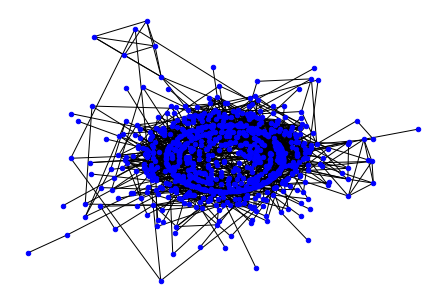

In [29]:
pos = nx.kamada_kawai_layout(G)
options = {
    "node_color": "blue",
    "node_size": 20,
    "line_color": "grey",
    "linewidths": 1,
    "width": 1,
}
nx.draw(G, pos, **options)
plt.savefig("name.svg")


In [30]:
len(G.nodes())

878

In [44]:
components = nx.connected_components(G)
nodes = next(components)
nodes

{'1312488',
 '1323119',
 '1376599',
 '1409597',
 '1421062',
 '1469002',
 '150061',
 '150251',
 '193002',
 '98019'}

In [45]:
graph = G.subgraph(nodes)
nx.shortest_path(graph, '1376599', '150251')

['1376599', '150251']